# 1. Imports

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np
from ast import literal_eval
import os
from glob import glob
import matplotlib.gridspec as gridspec

# 2. Cleaning

In [2]:
con = sqlite3.connect('../../Data/Experiment_1/experiment_data.db')
#subjs = pd.read_sql_query('SELECT * FROM subjects WHERE completion = 1', con)
dat = pd.read_sql_query('SELECT A.jspsychID,  A.trial_num, A.stimulus, A.cause_resp, A.anim_resp, A.cause_rt, A.anim_rt,'
            'A.trial_rt,A.time_elapse, A.subject_id '
            'FROM trials A INNER JOIN subjects B ON A.subject_id = B.id WHERE B.completion = 1 ORDER BY A.jspsychID ASC', con)

# Ensure all subjects have 48 trials
if dat.groupby('jspsychID').trial_num.count().sum() == len(dat.jspsychID.unique()) * 48:
    print(f'all N={len(dat.jspsychID.unique())} have data for all 48 trials.')

# Use the stimulus video file name to record trial condition participant viewed.
dat[['vid_num', 'agent', 'outcome', 'cf']] = dat.apply(lambda row: row['stimulus'].split(".")[0].split("_"), axis=1, result_type='expand')

# rename some variables for clarity
dat.agent.replace({'a':'animate', 'p':'inanimate'}, inplace=True)
dat.rename(columns={'cause_resp': 'causal_rating', 'anim_resp':'animacy_rating'}, inplace=True)


all N=105 have data for all 48 trials.


# 3. Manipulation Check

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


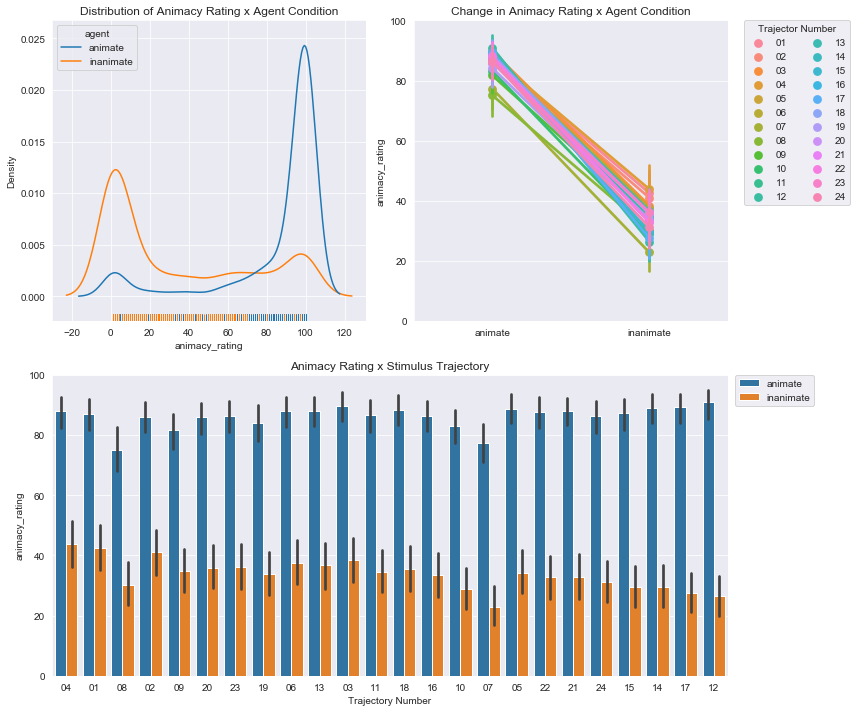

In [6]:
# difference in animacy rating by trajectory sorted from smallest to largest
anim_diffs = dat.groupby(['vid_num', 'agent']).animacy_rating.mean()
# sort the videos based on the difference of the mean animacy ratings per video
anim_diffs = anim_diffs.diff(-1).xs('animate', level=1).abs().sort_values()

fig = plt.figure(tight_layout=True, figsize=(12, 10))
gs = gridspec.GridSpec(2, 2)

a1 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data=dat, x='animacy_rating', hue='agent', ax=a1);
sns.rugplot(data=dat, x='animacy_rating', hue='agent', ax=a1);
a1.title.set_text('Distribution of Animacy Rating x Agent Condition')

a2 = fig.add_subplot(gs[0, 1])
sns.pointplot(data=dat, x='agent', y='animacy_rating', hue='vid_num', hue_order=sorted(dat.vid_num.unique().tolist()), ax=a2)
a2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,ncol=2)
a2.legend_.set_title('Trajector Number')
a2.set_xlabel('')
a2.set_ylim([0, 100])
a2.title.set_text('Change in Animacy Rating x Agent Condition')


a3 = fig.add_subplot(gs[1, :])
sns.barplot(data=dat, x='vid_num', y='animacy_rating', hue='agent', order=anim_diffs.index.tolist(), ax=a3)
a3.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

a3.set_ylim([0, 100])
a3.title.set_text('Animacy Rating x Stimulus Trajectory');
a3.set_xlabel('Trajectory Number');

#gs.update(top=.93, bottom=.02)
#fig.suptitle('Animacy Manipulation Check', y=.95);
#fig.savefig('Figures/e1_manip_chk.png', dpi=300)

# 4. Causality x Condition

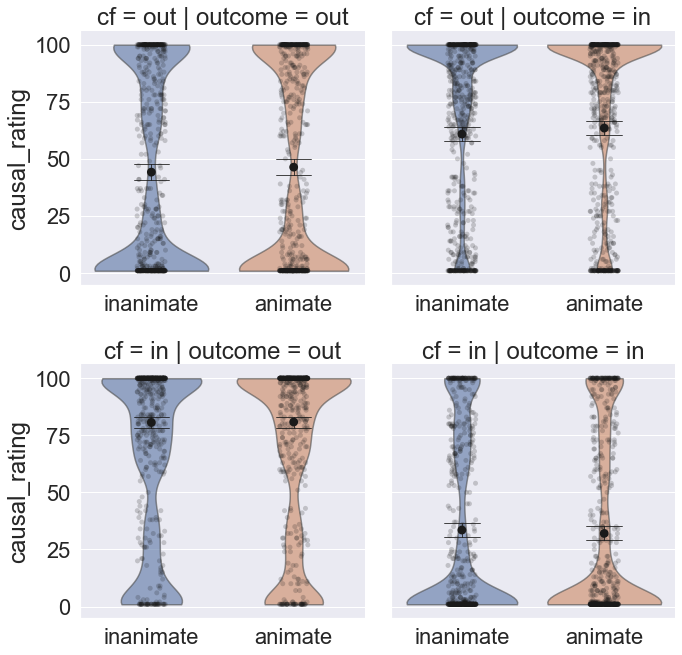

In [41]:
sns.set_style("white")
sns.set(font_scale=2)
g = sns.catplot(data=dat, x='agent',order=['inanimate', 'animate'], y='causal_rating', col='outcome', row='cf', kind='violin',  sharex=False, cut=0, inner=None, bw=.15)
for cond in list(itertools.product(dat.outcome.unique(), dat.cf.unique())):
    [x.set_alpha(.6) for x in g.axes_dict[cond].collections]
    sns.stripplot(data=dat.loc[(dat.outcome==cond[0]) & (dat.cf==cond[1])], x='agent', order=['inanimate', 'animate'], y='causal_rating', ax=g.axes_dict[cond], color='k', alpha=.2)
    sns.pointplot(data=dat.loc[(dat.outcome==cond[0]) & (dat.cf==cond[1])], x='agent', order=['inanimate', 'animate'], y='causal_rating', ax=g.axes_dict[cond], color='k', join=False, capsize=.25, errwidth=.8)
    g.axes_dict[cond].set_xlabel("")
g.fig.savefig('Figures/causexcondition.png', dpi=300)

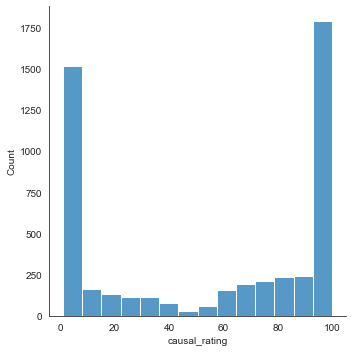

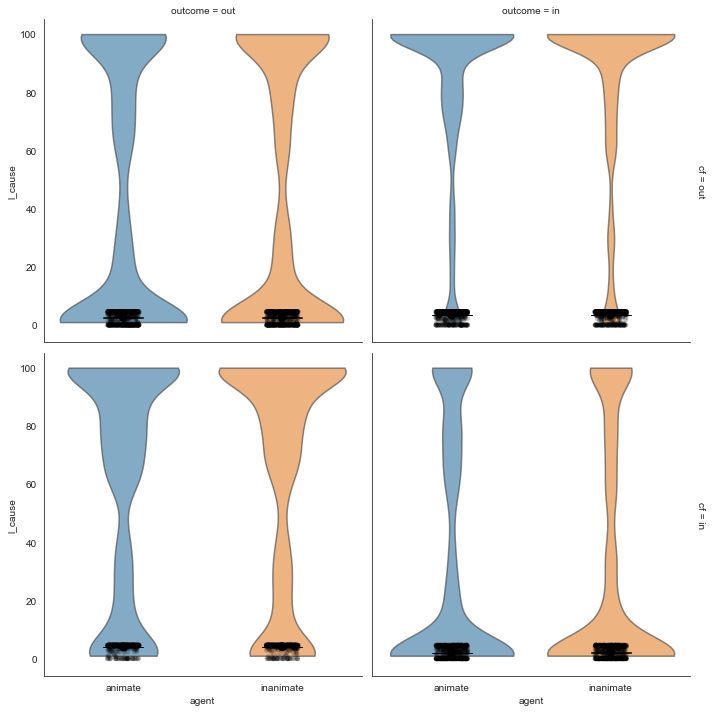

In [25]:
from scipy.stats import zscore

dat['l_cause'] = np.log(dat.causal_rating)
sns.displot(data=dat, x='causal_rating')
sns.set_style("white")
g = sns.catplot(data=dat, x='agent',order=['inanimate', 'animate'], y='causal_rating', col='outcome', row='cf', kind='violin',  cut=0, margin_titles=True, inner=None, bw=.15)
for cond in list(itertools.product(dat.outcome.unique(), dat.cf.unique())):
    [x.set_alpha(.6) for x in g.axes_dict[cond].collections]
    sns.stripplot(data=dat.loc[(dat.outcome==cond[0]) & (dat.cf==cond[1])], x='agent', y='l_cause', ax=g.axes_dict[cond], color='k', alpha=.2)
    sns.pointplot(data=dat.loc[(dat.outcome==cond[0]) & (dat.cf==cond[1])], x='agent', y='l_cause', ax=g.axes_dict[cond], color='k', ci=68, join=False, capsize=.25, errwidth=.8)

# 5. Causeality x Animacy

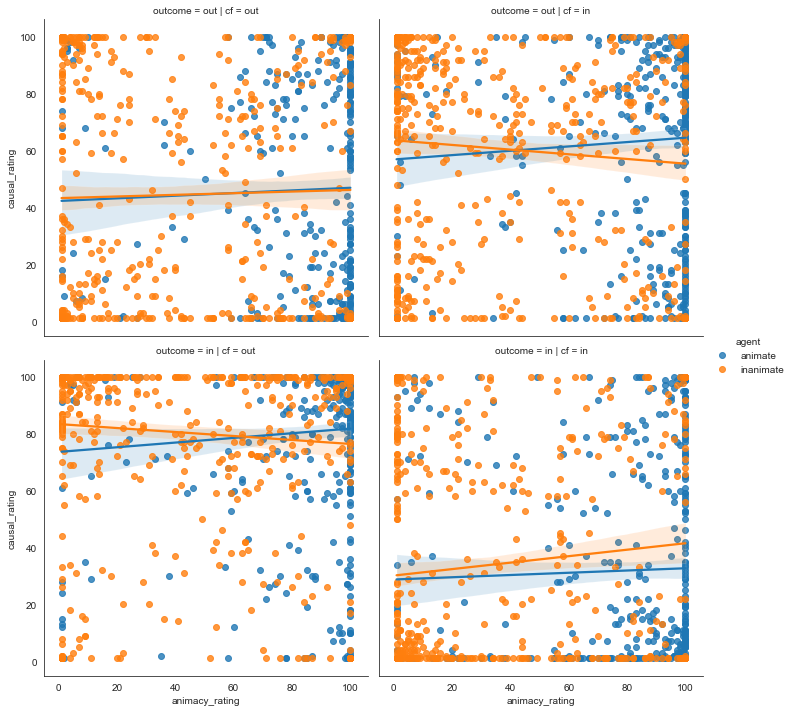

In [42]:
sns.lmplot(data=dat, x='animacy_rating', y='causal_rating', hue='agent', col='cf', row='outcome')


# Trajectories

In [26]:
anim_trajFiles = sorted(glob(os.path.join('../Experiment_1/collisions/trajectory_files', '*_a_*')))
phys_trajFiles = sorted(glob(os.path.join('../Experiment_1/collisions/trajectory_files', '*_p_*')))
cf_trajFiles = sorted(glob(os.path.join('../Experiment_1/collisions/trajectory_files', '*_cf_*')))


stim = pd.DataFrame(
    columns=['stimPath', 'stimFile', 'trajPath', 'cf_traj', 'agent_diff'],
    index=pd.MultiIndex.from_tuples(list(itertools.product([x+1 for x in range(24)], ['a', 'p'])), names=['traj_num','agent'])
)


In [27]:
stim=pd.DataFrame(
    index = ['0'+str(x) for x in range(1, 10)] +[str(x) for x in range(10,25)],
    columns= ['a_stimPath', 'a_stimFile', 'a_trajPath',
              'p_stimPath', 'p_stimFile', 'p_trajPath',
              'cf_traj', 'agent_diff', 'a_meanCause', 'p_meanCause'
              'a_meanAnim', 'p_meanAnim']
)


In [28]:
from utils import *

for vid in ['0'+str(x) for x in range(1, 10)] +[str(x) for x in range(10,25)]:
    for agnt in ['a', 'p']:
        s = sorted(glob(os.path.join('../../Studies/Experiment_1/billiards_app/static/videos', str(vid)+'_'+agnt+'*.mp4')))[0]
        t =sorted(glob(os.path.join('../Experiment_1/collisions/trajectory_files', str(vid)+'_'+agnt+'*.csv')))[0]
        stim.loc[vid, [agnt+'_stimPath', agnt+'_stimFile',  agnt+'_trajPath', agnt+'_meanCause', agnt+'_meanAnim']]  = \
            [s, s.split("/")[-1], t,
             float(dat.loc[dat.stimulus == s.split("/")[-1]].causal_rating.mean()),
            float(dat.loc[dat.stimulus == s.split("/")[-1]].animacy_rating.mean())]
    c = sorted(glob(os.path.join('../Experiment_1/collisions/trajectory_files', str(vid)+'_cf_*.csv')))[0]
    diff = trjct_diff_withinBall(traj1=get_trajectory(stim.loc[vid, 'a_trajPath']),
                                 traj2=get_trajectory(stim.loc[vid, 'p_trajPath']),
                                 ball='A')
    stim.loc[vid, ['agent_diff', 'cf_traj']] = [float(np.mean([i for i in diff if i > 0])) , c]

stim[['outcome', 'cf']] = stim.apply(lambda row: row['a_stimFile'].split(".")[0].split("_")[-2:], axis=1, result_type='expand')


a_stimPath                object
a_stimFile                object
a_trajPath                object
p_stimPath                object
p_stimFile                object
p_trajPath                object
cf_traj                   object
agent_diff               float64
a_meanCause              float64
p_meanCausea_meanAnim     object
p_meanAnim                object
a_meanAnim               float64
p_meanCause              float64
outcome                   object
cf                        object
dtype: object

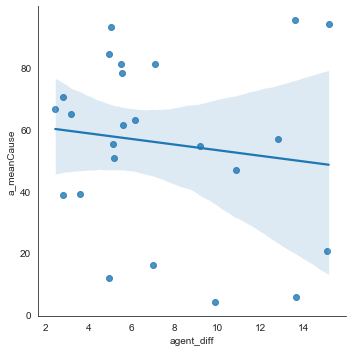

In [30]:
stim['agent_diff'] = stim.agent_diff.astype(float)
stim['a_meanCause'] = stim.a_meanCause.astype(float)
stim['a_meanAnim'] = stim.a_meanAnim.astype(float)
sns.lmplot(x='agent_diff', y = 'a_meanCause', data=stim)
stim.dtypes

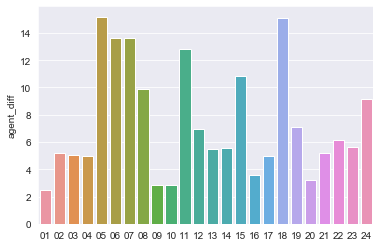

In [15]:
stim.agent_diff.idxmin()
sns.barplot(y='agent_diff', x=stim.index, data=stim)

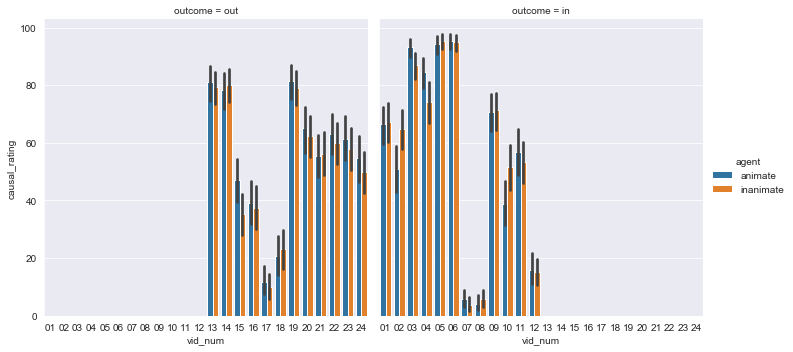

In [118]:
sns.catplot(x='vid_num', y='causal_rating', hue='agent', order = ['0'+str(x) for x in range(1, 10)] +[str(x) for x in range(10,25)], data=dat, kind='bar', col='outcome')

In [20]:
dat.to_csv('../../Data/e1dat.csv', sep=',')